In [1]:
# Load the models. 
# Encoder for encoding person voice, vocoder for mel2wav, and synthesizer for text embedding and reading it.
%matplotlib inline

from IPython.display import Audio
from IPython.utils import io
from synthesizer.inference import Synthesizer
from encoder import inference as encoder
from vocoder import inference as vocoder
from pathlib import Path
import numpy as np
import librosa
from matplotlib import pyplot as plt

encoder_weights = Path("encoder/saved_models/pretrained.pt")
vocoder_weights = Path("vocoder/saved_models/pretrained/pretrained.pt")
syn_dir = Path("synthesizer/saved_models/logs-pretrained/taco_pretrained")
encoder.load_model(encoder_weights)
synthesizer = Synthesizer(syn_dir)
vocoder.load_model(vocoder_weights)

Loaded encoder "pretrained.pt" trained to step 1564501
Found synthesizer "pretrained" trained to step 278000
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at vocoder\saved_models\pretrained\pretrained.pt


In [2]:
def get_synthetic_text_by_voice(voice_sample_addresses):
    embeds = []
    i = 0
    print('Embedding voice...')
    for voice_sample_address in voice_sample_addresses:
#         print('Embedding voice ', str(i))
        in_fpath = Path(voice_sample_address)
        original_wav, sampling_rate = librosa.load(in_fpath)
        preprocessed_wav = encoder.preprocess_wav(original_wav, sampling_rate)
        embed = encoder.embed_utterance(preprocessed_wav)
        embeds.append(embed)
        i+=1

    final_embed = np.asarray(embeds).mean(axis=0)

    print("Synthesizing new audio...")
    with io.capture_output() as captured:
        specs = synthesizer.synthesize_spectrograms([text], [final_embed])
    generated_wav = vocoder.infer_waveform(specs[0])
#     generated_wav = np.pad(generated_wav, (0, synthesizer.sample_rate), mode="constant")
    return generated_wav, specs


26
Embedding voice...
Synthesizing new audio...
{| ████████████████ 133000/134400 | Batch Size: 14 | Gen Rate: 19.8kHz | }

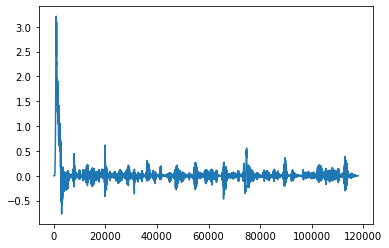

103
Embedding voice...
Synthesizing new audio...
{| ████████████████ 123500/124800 | Batch Size: 13 | Gen Rate: 18.9kHz | }

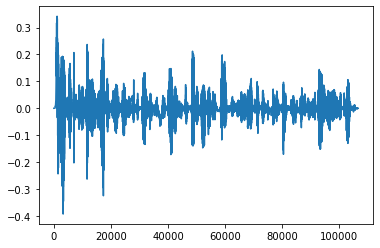

60
Embedding voice...
Synthesizing new audio...
{| ████████████████ 123500/124800 | Batch Size: 13 | Gen Rate: 18.2kHz | }

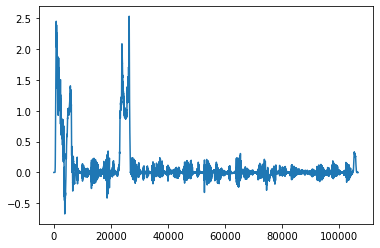

In [8]:
import os
import soundfile as sf

path_audio = 'E:/Projects/Git_folder/speaker_recognizer/libri/train-clean-100/LibriSpeech/train-clean-100/'
# text = "This is being said in my own voice. The computer has learned to do an impression of me, and now recording we are recoding this."
text = 'Well I think if he still has Covid, we should not have a debate. I think we are gonna have to follow very strict guidelines. Too many people have been infected and it is a very serious problem'
# text = "This is"


save_path = 'E:/Projects/Git_folder/speaker_recognizer/libri_voices_cloned/'
persons = ['26', '103', '60']
# persons = ['26']


max_utterances = 20

for p in persons:
    print(p)
    person_path = ''.join([path_audio, p, '/'])
    
    person_audio = os.listdir(person_path)
    all_utterances = []
    i = 0
    for f in person_audio:
        file_address = ''.join([person_path, f])
        utterances = os.listdir(file_address)
        
        for utterance in utterances:
            complete_address = (''.join([file_address, '/', utterance]))
            
            if complete_address[-4:] != 'flac':
                continue
            
            all_utterances.append(complete_address)
            i+=1
            if i >= max_utterances:
                break
        if i >= max_utterances:
            break
    generated_wav, specs = get_synthetic_text_by_voice(all_utterances)
    save_address = ''.join([save_path, p, '.wav'])
    sf.write(save_address, generated_wav, synthesizer.sample_rate)
    
    %matplotlib inline
    plt.plot(generated_wav)
    plt.show()

# display(Audio(generated_wav, rate=synthesizer.sample_rate))

In [19]:
int16_max = (2 ** 15) - 1
def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
    if increase_only and decrease_only:
        raise ValueError("Both increase only and decrease only are set")
    rms = np.sqrt(np.mean((wav * int16_max) ** 2))
    wave_dBFS = 20 * np.log10(rms / int16_max)
    dBFS_change = target_dBFS - wave_dBFS
    if dBFS_change < 0 and increase_only or dBFS_change > 0 and decrease_only:
        return wav
    return wav * (10 ** (dBFS_change / 20))

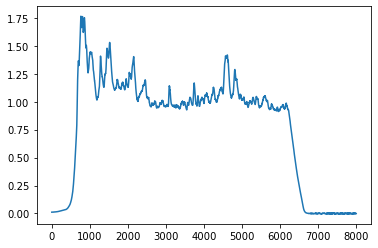

In [45]:
audio_norm_target_dBFS = -30
wav = normalize_volume(generated_wav, audio_norm_target_dBFS, increase_only=True)

plt.plot(wav[29000: 37000])

In [38]:
wav[29560]

0.2249881050930118

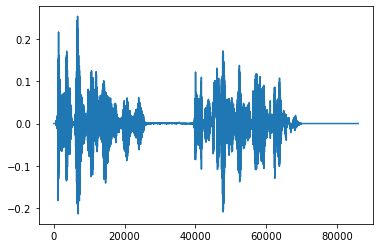

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(generated_wav)
plt.show()

In [6]:
folder_voices = 'E:/Projects/Git_folder/speaker_recognizer/libri/train-clean-100/LibriSpeech/train-clean-100/'


person_audio = os.listdir(person_path)
    all_utterances = []
    
    for f in person_audio: